In [300]:
import sys, os
import numpy as np
import netCDF4 as ncdf
import matplotlib.pylab as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib.offsetbox import AnchoredText
import matplotlib.ticker as ticker
from scipy import interpolate
import datetime as DT

ffile = "/Users/Louis.Wicker/FV3_ARW_FINAL/3km/nowind/fv3/fv3_history.nc"
ftime = 5
dx    = 3000.
rmax  = 15000.

afile = "/Users/Louis.Wicker/FV3_ARW_FINAL/3km/nowind/arw/wrfout_all.nc"
atime = ftime

ihwidth  = int(15000. / dx)
jhwidth  = int(15000. / dx)

z_interp = 50. + 100.*np.arange(151)

color    = ['blue','red','green']
name     = ['FV3', 'ARW']

In [301]:
def radial_profile(Z, P, wloc):
    
    nbins = 30
    r_coord = (rmax/nbins)*np.arange(nbins+1)

    i0 = wloc[1]-2*ihwidth
    i1 = wloc[1]+2*ihwidth
    j0 = wloc[0]-2*jhwidth
    j1 = wloc[0]+2*jhwidth
    
    x1d    = (-0.5*dx*(i1-i0) + dx*np.arange(i1-i0))
    y1d    = (-0.5*dx*(j1-j0) + dx*np.arange(j1-j0))
    theta  = np.arange(31) * 2.0*(np.pi) / float(30)
    
# first interpolate the variables to same heights   
    zt  = Z[:,j0:j1,i0:i1]
    ppt = P[:,j0:j1,i0:i1]
    
    zt1  = zt.reshape((-1,zt.shape[1]*zt.shape[2]))
    ppt1 = ppt.reshape((-1,ppt.shape[1]*ppt.shape[2]))

    pptmp = np.zeros((z_interp.shape[0],ppt1.shape[1]))

    for n in np.arange(ppt1.shape[1]):
        s = interpolate.InterpolatedUnivariateSpline(zt1[:,n], ppt1[:,n], ext=1)
        pptmp[:,n] = s(z_interp)
   
    ppZ = pptmp.reshape((-1,ppt.shape[1],ppt.shape[2]))
    
    print("Pert Pressure after Vert Interp: ",ppZ.min(), ppZ.max())

# Now interpret to a new x/y grid that has polar coordinates

    ppR = np.zeros((z_interp.shape[0],r_coord.shape[0]))
        
    for k in np.arange(ppZ.shape[0]):

        fz = interpolate.interp2d(x1d, y1d, ppZ[k,:,:], kind='linear')

        for nr, r in enumerate(r_coord):
            xr        = r * np.cos(theta)
            yr        = r * np.sin(theta)
            ppR[k,nr] = fz(xr,yr).mean()
            
    print("Radial Pressure Stats: ",ppR.min(), ppR.max())
                        
    return z_interp/1000., r_coord/1000., ppR


In [302]:
def create_profiles(Z, P, wloc):

    i0 = wloc[1]-ihwidth
    i1 = wloc[1]+ihwidth
    j0 = wloc[0]-jhwidth
    j1 = wloc[0]+jhwidth
    
    zt  = Z[:,j0:j1,i0:i1]
    ppt = P[:,j0:j1,i0:i1]
    zt  = zt.reshape((-1,zt.shape[1]*zt.shape[2]))
    ppt = ppt.reshape((-1,ppt.shape[1]*ppt.shape[2]))
    
    print("pertP: ",ppt.max(), ppt.min())
    
    ppinterp = np.zeros((z_interp.shape[0],ppt.shape[1]))

    zzinterp = np.zeros((z_interp.shape[0],ppt.shape[1]))

    for n in np.arange(ppt.shape[1]):
        s = interpolate.InterpolatedUnivariateSpline(zt[:,n], ppt[:,n], ext=1)
        ppinterp[:,n] = s(z_interp)
        zzinterp[:,n] = z_interp

    return zzinterp.flatten()/1000., ppinterp.flatten()


#     wintrp = np.zeros((pintrp.shape[0],wraw.shape[1]))

In [303]:
print('\n ----FV3----\n')
step = int(ftime / 5) - 1
f    = ncdf.Dataset(ffile, "r+")

# get the model times
units     = f['time'].units
tarray    = f['time'][:]
init_time = units.split('since')[1][1:]                                          # strip out COARDS info
init      = DT.datetime.strptime(init_time, '%Y-%m-%d %H:%M:%S')                 # create a datetime object
init2     = DT.datetime.strptime("2019-05-20 22:00:00", '%Y-%m-%d %H:%M:%S')
DateTimeArray  = [init + DT.timedelta(minutes=int(s)) for s in tarray ]          # this is a list!

#time = DT.datetime.strftime(DateTimeArray[step]-init2, '%M')                    # create a datetime object
time = int((DateTimeArray[step]-init2).seconds/60)

nt, nz, ny, nx = f.variables['pres'][...].shape

z = np.cumsum(f.variables['delz'][step,::-1,:,:],axis=0)

p0   = f.variables['pres'][0,::-1,:,:] / 100.
pi0  = (p0/1000.)**0.285
p    = f.variables['pres'][step,::-1,:,:] / 100.
pi   = (p/1000.)**0.285
pp   = p - p0

print("P: ",p.max(), p.min())
print("pertP: ",pp.max(), pp.min())
print("PI: ",pi.max(), pi.min())

w    = f.variables['dzdt'][step,::-1,:,:]

wloc = np.unravel_index(np.argmax(w.max(axis=0), axis=None), w.shape[1:])
wloc = np.array(wloc)

data = []
Rdata = []

Rdata.append(radial_profile(z, pp, wloc))
data.append(create_profiles(z, pp, wloc)) 

del(f)

#---------------------------------
print('\n ----ARW----\n')
step = int(ftime / 5)

f  = ncdf.Dataset(afile, "r")

zstag = (f.variables['PH'][step,:,:]+f.variables['PHB'][step,:,:]) / 9.806
z     = (zstag[:-1]+zstag[1:])/2

nz, ny, nx = z.shape

pbar = f.variables['PB'][0,:,:,:]
pi0  = (1.0e5/pbar)**0.285
p    = f.variables['P'][step,:,:,:] + pbar
pi   = (1.0e5/p)**0.285
pp   = (p - pbar) / 100.

print("P: ",p.max(), p.min())
print("pertP: ",pp.max(), pp.min())
print("PI: ",pi.max(), pi.min())
print("PI0: ",pi.max(), pi.min())

wstag  = f.variables['W'][step,:,:,:]
w      = (wstag[:-1]+wstag[1:])/2

wloc = np.unravel_index(np.argmax(w.max(axis=0), axis=None), w.shape[1:])
wloc = np.array(wloc)

data.append(create_profiles(z, pp, wloc)) 

Rdata.append(radial_profile(z, pp, wloc))



 ----FV3----

P:  1002.0043 12.3743105
pertP:  0.0 0.0
PI:  1.0005708 0.28600162
Pert Pressure after Vert Interp:  0.0 0.0
Radial Pressure Stats:  0.0 0.0
pertP:  0.0 0.0

 ----ARW----

P:  99903.6 1436.5421
pertP:  0.025625 -2.9682422
PI:  3.3509216 1.0002749
PI0:  3.3509216 1.0002749
pertP:  -0.0076379394 -2.9682422
Pert Pressure after Vert Interp:  -2.9682354644509616 -0.04985174133228143
Radial Pressure Stats:  -2.9682354644509625 -0.12050921531458833


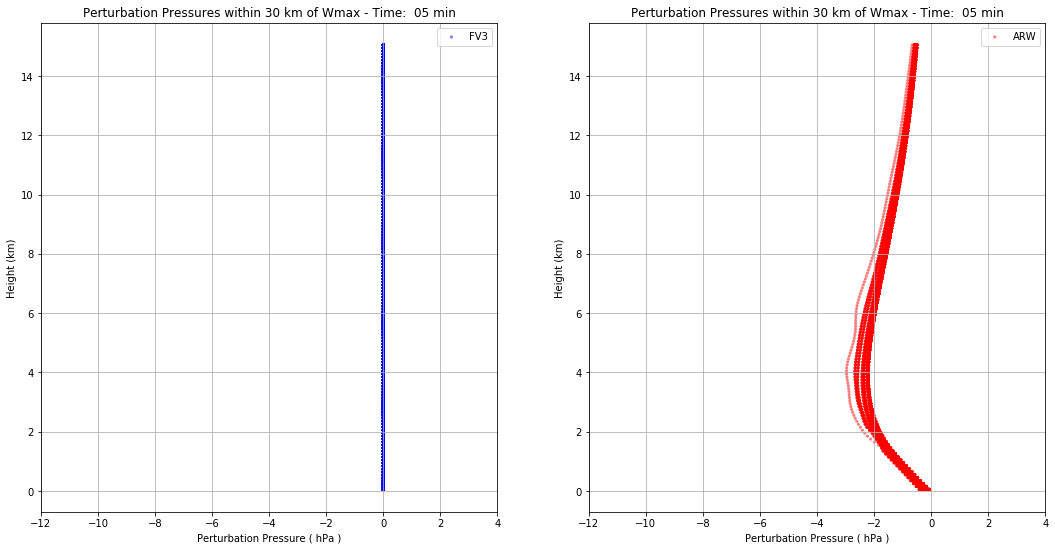

In [304]:
fig, axes = plt.subplots(1,2, figsize=(18,9))

for n, ax in enumerate(axes):

    ax.scatter(data[n][1], data[n][0], c=color[n], s=10., label=name[n],
                   alpha=0.5, edgecolors='none')

    ax.set_title('Perturbation Pressures within 30 km of Wmax - Time:  %2.2d min' % ftime)
    ax.set_xlabel("Perturbation Pressure ( hPa )" )
    ax.set_ylabel('Height (km)' )
    ax.set_xlim(-12.0, 4.0)

    ax.legend()
    ax.grid(True)

/Users/Louis.Wicker/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: No contour levels were found within the data range.
  if __name__ == '__main__':


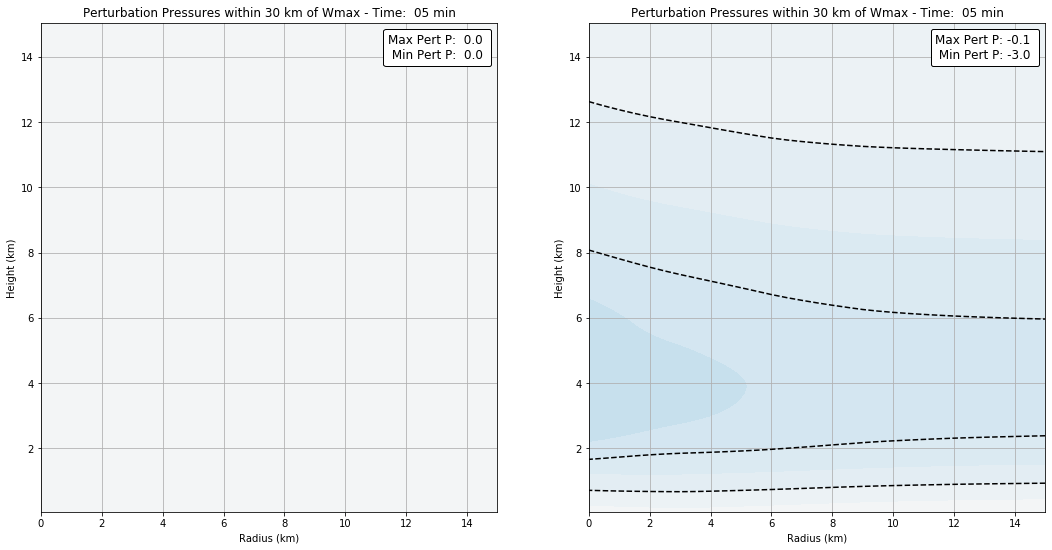

In [305]:
fig, axes = plt.subplots(1,2, figsize=(18,9))

clevels = -12.+ 0.5*np.arange(49)

for n, ax in enumerate(axes):
    
    ax.contourf(Rdata[n][1], Rdata[n][0], Rdata[n][2], cmap="RdBu_r", levels=clevels)

    ax.contour(Rdata[n][1], Rdata[n][0], Rdata[n][2], colors='k', levels=clevels[::2])


    ax.set_title('Perturbation Pressures within 30 km of Wmax - Time:  %2.2d min' % ftime)
    ax.set_xlabel('Radius (km)' )
    ax.set_ylabel('Height (km)' )
    ax.set_xlim(0.0, rmax/1000.)
    at = AnchoredText("Max Pert P: %4.1f \n Min Pert P: %4.1f" % (Rdata[n][2].max(),Rdata[n][2].min()), \
                      loc=1, prop=dict(size=12), frameon=True,)
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)

    ax.grid(True)